# Following the Video Code

For notes and to ensure understanding.

In [1]:
from functools import partial
import torch

import seaborn as sns
from numpy.random import normal

from ipywidgets import interact

In [2]:
# set plot style for dark mode (not necessary to understand the notebook)
sns.set_theme(rc={
                  'font.size': 10,
                  'xtick.labelsize': 8,
                  'ytick.labelsize': 8,
                  'axes.labelsize': 8,
                  'axes.spines.right': False,
                  'axes.spines.top': False,
                  'axes.facecolor': '#1E1E1E',  # Very dark gray
                  'figure.facecolor': '#1E1E1E',  # Very dark gray
                  'axes.grid': False,
                  'xtick.color': 'w',  # White x-axis tick labels
                  'ytick.color': 'w',  # White y-axis tick labels
                  'text.color': 'w',  # White text
                  'axes.labelcolor': 'w',  # White axis labels
                  'figure.titlesize': 'large',  # Set the size of the figure title
                  'figure.titleweight': 'bold',  # Set the weight of the figure title
              })

# store a colour palette
col_pal = sns.color_palette("muted")
sns.set_palette(col_pal)

In [27]:
def quad(a, b, c, x):
    return a*x ** 2 + b*x + c

quad(3, 2, 1, 2)

17

In [28]:
f = partial(quad, 3, 2, 1)
f(2)

17

In [29]:
x = torch.linspace(-2, 2, 40)
x

tensor([-2.0000, -1.8974, -1.7949, -1.6923, -1.5897, -1.4872, -1.3846, -1.2821,
        -1.1795, -1.0769, -0.9744, -0.8718, -0.7692, -0.6667, -0.5641, -0.4615,
        -0.3590, -0.2564, -0.1538, -0.0513,  0.0513,  0.1538,  0.2564,  0.3590,
         0.4615,  0.5641,  0.6667,  0.7692,  0.8718,  0.9744,  1.0769,  1.1795,
         1.2821,  1.3846,  1.4872,  1.5897,  1.6923,  1.7949,  1.8974,  2.0000])

In [6]:
y = f(x)
y

tensor([ 9.0000,  8.0059,  7.0750,  6.2071,  5.4024,  4.6607,  3.9822,  3.3669,
         2.8146,  2.3254,  1.8994,  1.5365,  1.2367,  1.0000,  0.8264,  0.7160,
         0.6686,  0.6844,  0.7633,  0.9053,  1.1105,  1.3787,  1.7101,  2.1045,
         2.5621,  3.0828,  3.6667,  4.3136,  5.0237,  5.7968,  6.6331,  7.5325,
         8.4951,  9.5207, 10.6095, 11.7613, 12.9763, 14.2544, 15.5957, 17.0000])

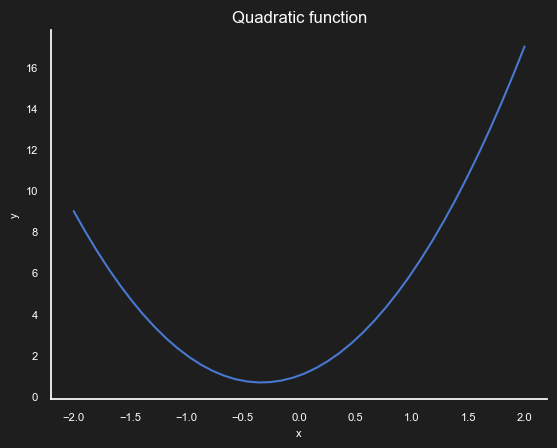

In [7]:
sns.lineplot(x=x, y=y).set(title='Quadratic function', 
                           xlabel='x', 
                           ylabel='y');

In [8]:
x.size()

torch.Size([40])

In [9]:
def add_noise(x, mult, add):
    mult_noise = 1 + normal(scale=mult, size=x.size())
    add_noise = normal(scale=add, size=x.size())
    return x * mult_noise + add_noise

data_y = add_noise(y, 0.3, 1.2)

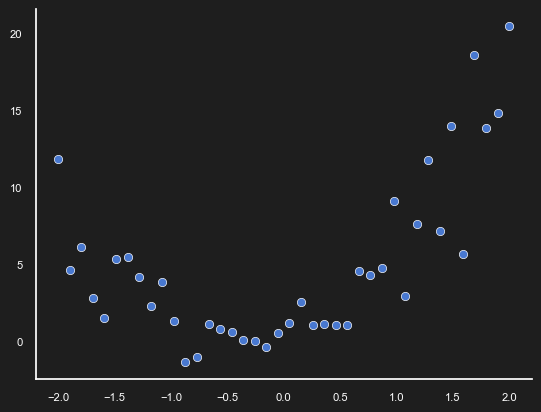

In [10]:
sns.scatterplot(x=x, y=data_y);

## Fit by Hand

In [49]:
def mk_quad(a,b,c): return partial(quad, a, b, c)

In [50]:
@interact(a=1.5, b=1.5, c=1.5)
def explore_quad_coefs(a, b, c):
    sns.scatterplot(x=x, y=data_y)
    
    f = mk_quad(a, b, c)
    y = f(x)
    sns.lineplot(x=x, y=y).set(ylim=[-3, 20])

interactive(children=(FloatSlider(value=1.5, description='a', max=4.5, min=-1.5), FloatSlider(value=1.5, descr…

In [12]:
def mse(real, pred):
    return ((real - pred)**2).mean()

In [47]:
@interact(a=1.5, b=1.5, c=1.5)
def explore_quad_coefs(a, b, c):
    sns.scatterplot(x=x, y=data_y)
    
    f = partial(quad, a, b, c)
    y = f(x)
    loss = mse(data_y, y)
    sns.lineplot(x=x, y=y).set(ylim=[-3, 20], title=f'MSE: {loss:.2f}')

interactive(children=(FloatSlider(value=1.5, description='a', max=4.5, min=-1.5), FloatSlider(value=1.5, descr…

## Automate Fitting with Loss

In [83]:
def quad_mse(params):
    f = mk_quad(*params)
    return mse(data_y, f(x))

In [84]:
quad_mse([1.5, 1.5, 1.5])

tensor(12.2818, dtype=torch.float64)

In [85]:
abc = torch.tensor([1.5, 1.5, 1.5])
abc.requires_grad_()

tensor([1.5000, 1.5000, 1.5000], requires_grad=True)

Requires grad means that every time the tensor is used in a function the gradient is calculated.

In [86]:
loss = quad_mse(abc)
loss

tensor(12.2818, dtype=torch.float64, grad_fn=<MeanBackward0>)

In [87]:
loss.backward()

In [88]:
abc.grad

tensor([-8.9446, -2.5472, -2.6136])

We don't want the gradient to be calculated when we use ```abc -= abc.grad*1e-2``` because this is us updating the gradient, not the loss function itself. 

In [89]:
with torch.no_grad():
    abc -= abc.grad*1e-2
    loss = quad_mse(abc)

print(f'loss={loss:.2f}')

loss=11.39


In [90]:
loss

tensor(11.3850, dtype=torch.float64)

In [91]:
for i in range(5):
    loss = quad_mse(abc)
    loss.backward()
    with torch.no_grad():
        abc -= abc.grad*1e-2
    print(f'step = {i}, loss = {loss:.2f}')
    

step = 0, loss = 11.39
step = 1, loss = 9.87
step = 2, loss = 8.18
step = 3, loss = 6.84
step = 4, loss = 6.21


In [92]:
abc

tensor([2.9314, 1.9866, 1.8575], requires_grad=True)

In [93]:
def rectified_linear(m, b, x):
    y = m*x + b
    return torch.clip(y, 0.)

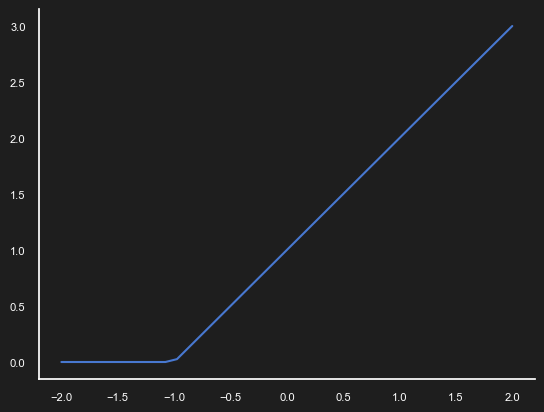

In [96]:
sns.lineplot(x=x, y=rectified_linear(1,1, x));